# Import Dependencies

In [ ]:
!apt-get install -y xvfb python3-opengl ffmpeg > /dev/null 2>&1
!pip install gym[classic_control]
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup gym pyvirtualdisplay tensorflow ffmpeg imageio-ffmpeg > /dev/null 2>&1

In [4]:
import math
import os
from typing import Dict, List, Tuple
from abc import ABC, abstractmethod
from gym import make
import numpy as np
from gym.wrappers.record_video import RecordVideo
import pickle
from typing import NamedTuple
from collections import defaultdict
from matplotlib import pyplot as plt
import random

# Load Cartpole Environment

We define a custom `CartPoleWorld` class to represent the cartpole environment. 

In [7]:
"""
Observation tuple to store the 4 different states of the cartpole environment
"""
class Observation(NamedTuple):
    d: float
    x: float
    theta: float
    omega: float

In [8]:
'''
Update CartPoleWord class here
'''   
class CartpoleWorld():
    def __init__(self, display: bool = False) -> None:
        if display:
            self.__env = make("CartPole-v1", render_mode="human")
        else:
            self.__env = make("CartPole-v1")
        self.__observation: np.ndarray
        self.__reward: float = 0
        self.__truncated: bool  = False
        self.__done: bool = False
        self.__observation, _ = self.__env.reset()
    
    def get_actionspace(self):
        return self.__env.action_space
        
    def get_observation(self) -> np.ndarray:
        return self.__observation
    
    def update_world(self,action) -> float:
        self.__observation, self.__reward, self.__truncated, self.__done, _ = self.__env.step(action)
        return self.__reward
    
    def isEnd(self) -> bool:
        # position range
        if not (-2.4 < self.__observation[0] < 2.4):
            return True
        # angle range
        if not (-.2095 < self.__observation[2] < .2095):
            return True
        return self.__done or self.__truncated
    
    def get_reward(self) -> float:
        return self.__reward
    
    def resetWorld(self) -> Observation:
        self.__observation, _ = self.__env.reset()
        self.__reward = 0
        self.__done = False
        self.__truncated  = False
        return Observation(*self.__observation)
        
    def set_to_display_mode(self) -> None:
        self.__env = make("CartPole-v1", render_mode="human")
        self.__observation, _ = self.__env.reset()
        
    def set_save_video(self) -> None:
        self.__env  = make("CartPole-v1", render_mode="rgb_array_list")
        self.__env  = RecordVideo(self.__env , video_folder="video", name_prefix = "rl-video")
        
world = CartpoleWorld()

Check if there are 2 valid discrete actions that can be performed.

The action is an ndarray with shape (1,) which can take values {0, 1} indicating pushing the cart to the left or right, respectively. Note that the velocity that is reduced or increased by the applied force is not fixed and it depends on the angle the pole is pointing. The center of gravity of the pole varies the amount of energy needed to move the cart underneath it.

In [ ]:
world.get_actionspace()

Display observable space. Note the format of the space being
{
    position,
    velocity,
    pole angle,
    pole angular velocity,
}

In [ ]:
world.get_observation()

In [ ]:
world.resetWorld()
print("Initial observations:", world.get_observation())

### Base RL Agent

We define an abstract base RL agent as follows:

In [9]:
class RLAgent(ABC):
    def __init__(self, env:CartpoleWorld) -> None:
        self._env = env
        self._total_reward: float = 0
        
    @abstractmethod
    def get_optimal_action(self, s: Observation) -> int:
        pass
    
    def move(self, state: Observation) -> float:
        if (self._env.isEnd()):
            raise Exception("Episode already terminated")
        action = self.get_optimal_action(state)
        reward = self._env.update_world(action)
        # update reward
        self._total_reward += reward
        return reward
    
    @abstractmethod
    def run_single_episode_training(self) -> int:
        pass
    
    @abstractmethod
    def run_single_episode_production(self) -> int:
        pass
    
    def wrap_observation(self, observation: np.ndarray) -> Observation:
        """Converts numpy array to Observation object

        Args:
            observation (np.ndarray): array to pass in from cartpole

        Returns:
            Observation: Object to return
        """
        return Observation(*observation)
    
    def discretise_observation(self, observation: np.ndarray) -> Observation:
        # Position round off to 0.1 precision
        # Velocity round off to whole
        # Angle round off to 0.01 precision
        # Velocity round off to whole
        observation[0] = round(observation[0],1)
        observation[1] = round(observation[1],0)
        observation[2] = round(observation[2],2)
        observation[3] = round(observation[3],0)
        return Observation(*observation)
    

# Task 1

Development of an RL agent. Demonstrate the correctness of the implementation by sampling a random state from the cart pole environment, inputting to the agent, and outputting a chosen action. Print the values of the state and chosen action in Jupyter notebook.

## 1a) Monte Carlo Agent

We first attempt to implement a Monte Carlo agent. Being the very first topic introduced in the lecture of Reinforcement Learning, it is also one of the easiest to implement. We use this agent as a baseline performance measure.

### Explanation of Monte Carlo Agent

  - Find stuff talking about MC sampling
  - Motivation for using a hybrid initial policy (as compared to pure random sampling)
  - Motivation for using a decaying epsilon rate
  - How does the agent obtain the optimal action
  - How does the agent update the q-table

In [5]:
class MCAgent(RLAgent):
    """MC agent

    Args:
        RLAgent (class): Abstract base class
    """
    def __init__(self, env: CartpoleWorld, load_pickle = False) -> None:
        #super().__init__(env)
        #for convenience
        self.env = env

        self.total_reward = 0
        self.num_runs = 0

        self.actions = [0,1]

        self.epsilon = 0.9
        self.min_epsilon = 0.1
        self.gamma = 0.99

        # Format: dict[(state,action)] = [value]
        self.Q = defaultdict(int)
        self.returns = defaultdict(int)
        self.visits = defaultdict(int)
        self.history = []

        if load_pickle:
            self.load_pickle("MC_parameters.pkl")

    # Not Used
    def geometric_progression(self, n: int) -> float:
        # Calcuate rewards based on the formula S = a(1 - r^n) / (1-r)
        return (1 - (self.gamma ** n)) / (1 - self.gamma)


    def decay_epsilon(self):
        self.epsilon = max(self.epsilon * 0.99999, self.min_epsilon)
    

    def run_single_episode_training(self) -> int:
        reward = self.run_single_episode_production()
        self.update_q_table()
        return reward
    

    def run_single_episode_production(self) -> int:
        self.env.resetWorld()
        history = []
        total_reward = 0

        while (not self.env.isEnd()):
            ndarry: np.ndarray = self.env.get_observation()
            s = Observation(*self.discretise_observation(ndarry))

            action = self.get_optimal_action(s)
            reward = self.env.update_world(action)
            history.append((s, action, reward))
            total_reward += reward

        self.decay_epsilon()
        self.num_runs += 1
        self.history = history
        self.total_reward += total_reward    
        return total_reward
    
    def run_production(self, num_of_episode: int) -> None:
        return super().run_production(num_of_episode)
    
    def update_q_table(self) -> None:
        history = self.history
        state_action_pair = defaultdict(int)
        G = 0

        # Adopts first visit by updating from the back
        # Hence, only the first occurence of each (state,action) pair will be recorded
        for i in range(len(history)-1, -1, -1):
            state, action, reward = history[i]
            G = self.gamma * G + reward
            state_action_pair[(state, action)] = G

        for key,val in state_action_pair.items():
            self.returns[key] += val
            self.visits[key] += 1
            self.Q[key] = self.returns[key] / self.visits[key]


    def get_optimal_action(self, s: Observation):
        
        # self.epsilon starts at 0.9, slowly decreases till a minimum of 0.1
        if random.random() <= self.epsilon:
            action = 1 if s[2] > 0 else 0
            # Chooses the physics action which a probability of 0.7, and the other action with a prob of 0.3
            return action if random.random() <= 0.70 else 1 - action
        
        return max(self.actions, key=lambda a: self.Q[(s,a)])


    def load_pickle(self, parameters_file: str):
        """Loads pickle file to agent table

        Args:
            parameters (str): pickle file location
        """
        if os.path.exists(parameters_file):
            with open(parameters_file, 'rb') as file:
                # Call load method to deserialze
                Q, returns, visits, self.epsilon = pickle.load(file)
                self.Q = defaultdict(int, Q)
                self.returns = defaultdict(int, returns)
                self.visits = defaultdict(int, visits)
        else:
            print("*** LOG: Pickle file not found")
            pass
        
    def save_pickle(self, parameters_file: str):
        """Saves q and pi table to pickle.

        Args:
            pi_table_file (str): location of file
            q_table_file (str): location of file
        """
        with open(parameters_file, 'wb') as file:
            # Call load method to deserialze
            pickle.dump([dict(self.Q), dict(self.returns), dict(self.visits), self.epsilon], file)

    def print_average(self):
        print(f"avg_reward: {self.total_reward/self.num_runs}")
    
    def run_training_for_plot(self,  num_of_episode: int) -> float:
        cumulated_reward = 0
        for _ in range(num_of_episode):
            cumulated_reward += self.run_single_episode_training()
        return cumulated_reward/num_of_episode


mc_agent = MCAgent(world, load_pickle=False)

### Development of Monte Carlo Agent
Below is the graph of how the MC agent develops over 10,000 iterations. we are interested in the initial rate of growth and how the agent progresses over time as it learns the optimal actions.

/home/tng042/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


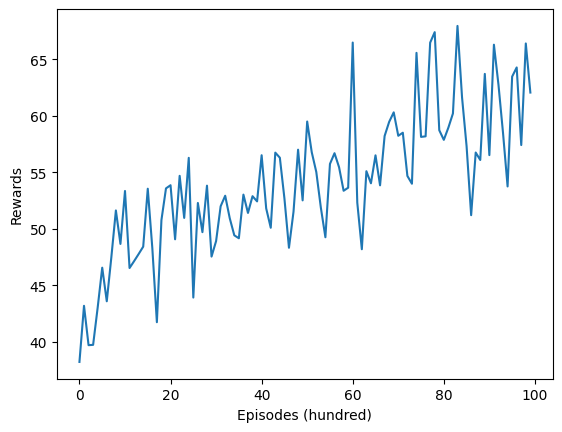

In [6]:
mc_agent = MCAgent(world, load_pickle=False)
fig, ax = plt.subplots()  
reward_list = [mc_agent.run_training_for_plot(100) for _ in range(100)]

plt.plot(reward_list)
ax.set_ylabel('Rewards')
ax.set_xlabel('Episodes (hundred)')
plt.show()

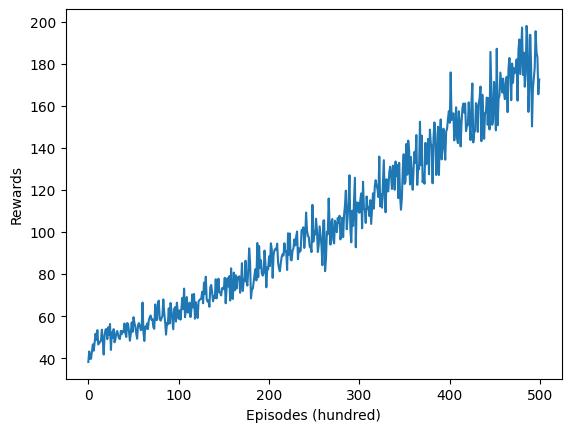

In [7]:
fig, ax = plt.subplots()  
reward_list.extend([mc_agent.run_training_for_plot(100) for _ in range(400)])

plt.plot(reward_list)
ax.set_ylabel('Rewards')
ax.set_xlabel('Episodes (hundred)')
plt.show()

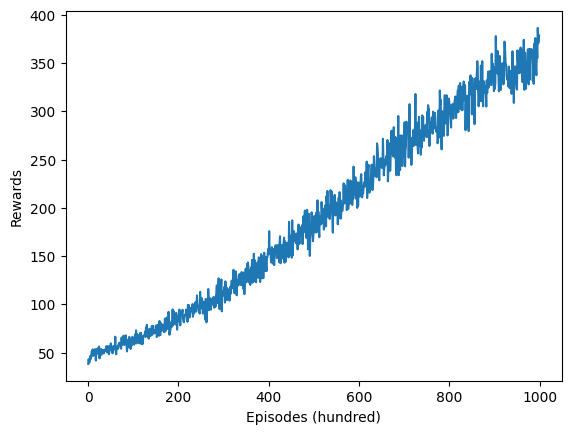

In [8]:
fig, ax = plt.subplots()  
reward_list.extend([mc_agent.run_training_for_plot(100) for _ in range(500)])

plt.plot(reward_list)
ax.set_ylabel('Rewards')
ax.set_xlabel('Episodes (hundred)')
plt.show()

### Correctness of implementation

In [ ]:
observation = world.resetWorld()
action = mc_agent.get_optimal_action(observation)
print(f"{observation}")
print(f"Chosen Action: {action}")

## 1b) Q-Learning Agent

The second agent we implemented was a Q-Learning Agent. Being the second topic taught in the lecture, it is an off-policy reinforcement learning that will find the best course of action, given the current state of the agent.

### Explanation of Q-Learning Agent

- Agent is implemented with decaying epsilon and learning rate
    - Epsilon is set to decay to encourage exploration in the inital phase of training. As more experience is gathered, the agent should exploit this knowledge to maximise rewards. Epsilon threshold is set to prevent decay to 0.
    - Learning rate is also decaying to encourage large jumps towards minima. As the agent optimises, the steps should be smaller to ensure that minima is not missed

- Getting optimal action
    - Agent computes the action that maximises Q value from the Q-table (arg_max_a). All possible actions for the states are enumerated and the best action is returned
    - An epsilon soft policy is used to evaluate if a random action should be taken

- Q-table update
    - The Q-table is updated using the formula from the lecture slides
    - The equation can be rewritten as $(1-\alpha) Q_{old}(s_t,a_t) + \alpha (Reward_{t+1} + \gamma max_a(Q_{old}(s_{t+1},a)))$

In [10]:
# define constants
MULTIPLICATIVE_DECAY=0
EXPONENTIAL_DECAY=1

class QLearningAgent(RLAgent):
    """Q-learning agent

    Args:
        RLAgent (class): Abstract base class
    """
    def __init__(self, env:CartpoleWorld, to_load_pickle=True, to_save_pickle=True,
                 max_epoch=100000, epsilon=0.9, epsilon_decay=MULTIPLICATIVE_DECAY, learing_rate_min=0.1) -> None:
        super().__init__(env)
        
        # defines learning rate
        self.__learning_rate = 0.5
        self.__learning_rate_min = learing_rate_min
        
        # defined for epsilon soft policy
        # initially set to a large number to encourage exploration
        # epsilon will decay as episodes increase
        self.__epsilon_decay = epsilon_decay
        self.__num_epoch = 0
        self.__max_epoch = max_epoch
        self.__epsilon = epsilon
        self._epsilon_min = 0.01
        
        # dictionary of (state,action) -> quality
        self.__q_table : Dict[Tuple[Observation,int],float] = dict()
        self.__pi_table : Dict[Observation, int] = dict()
        
        # Load pickle file to restore agent previous state
        if (to_load_pickle):
            self.load_pickle('QL_parameters.pkl')
        self.__to_save_pickle = to_save_pickle
        
        # [left, right] action set
        self.__actions = [0,1]
        self.__discounted_reward = 0.9
        
        # parameter for production
        self.__is_production = False
    
    def print_parameters(self) -> None:
        print(f"Epsilon: {self.__epsilon:2f}, Current epoch: {self.__num_epoch}, Learning rate: {self.__learning_rate:2f}")

    
    def update_parameters(self) -> None:
        self.decay_epsilon()
        self.decay_learning_rate()
    
    def decay_epsilon(self) -> None:
        if self.__epsilon <= self._epsilon_min:
            return
        
        self.__num_epoch +=1
        if (self.__epsilon_decay==MULTIPLICATIVE_DECAY):
            # multiplicative decrease
            self.__epsilon *= 0.99999
        else:
            # exponential decrease
            # hyperparamters to tune
            A=0.5
            B=0.1
            C=0.1
            standardized_time=(self.__num_epoch-A*self.__max_epoch)/(B*self.__max_epoch)
            cosh=np.cosh(math.exp(-standardized_time))
            self.__epsilon=1.1-(1/cosh+(self.__num_epoch*C/self.__max_epoch))
    
    def decay_learning_rate(self) -> None:
        if self.__learning_rate <= self.__learning_rate_min:
            return
        self.__learning_rate *= 0.99995
    
    def train_till_complete(self, threshold: int, bin_size: int) -> List:
        self.__is_production = False
        cumulated_reward = 0
        reward_history = list()
        self.__num_epoch = 0
        while(cumulated_reward/bin_size < threshold):
            cumulated_reward = 0
            for _ in range(bin_size):
                reward = self.run_single_episode_training()
                cumulated_reward += reward
                self.__num_epoch += 1
            reward_history.append(cumulated_reward/bin_size)
        self.print_parameters()
        return reward_history

    def run_training(self,  num_of_episode: int) -> List:
        """Overrides base class method

        Args:
            num_of_episode (int): Number of episode to run
        """
        self.__is_production = False
        cumulated_reward = 0
        reward_history = list()
        self.__num_epoch = 0
        
        for _ in range(int(num_of_episode/100)):
            cumulated_reward = 0
            for _ in range(100):
                reward = self.run_single_episode_training()
                cumulated_reward += reward
                self.__num_epoch += 1
            reward_history.append(cumulated_reward/100)

        self.print_parameters()
        if (self.__to_save_pickle):
            self.save_pickle("QL_parameters.pkl")
        return reward_history
    
    def run_training_for_plot(self,  num_of_episode: int) -> float:
        cumulated_reward = 0
        for _ in range(num_of_episode):
            cumulated_reward += self.run_single_episode_training()
        return cumulated_reward/num_of_episode
    
    def run_production(self, num_of_episode: int):
        self.__is_production = True
        
        cumulated_reward = 0
        for _ in range(num_of_episode):
            cumulated_reward += self.run_single_episode_production()

        print(f"Mean reward is: {cumulated_reward/num_of_episode} for {num_of_episode} episodes")

    def run_single_episode_training(self) -> int:
        # clear history
        self._env.resetWorld()
        self._total_reward = 0
        
        s_prime = self._env.get_observation()
        s_prime = self.discretise_observation(s_prime)
        
        while (not self._env.isEnd()):
            s = s_prime
            R = self.move(s)
            s_prime = self._env.get_observation()
            s_prime = self.discretise_observation(s_prime)
            
            self.update_q_table(s,R,s_prime)
            
        self.update_parameters()
        return self._total_reward
    
    def run_single_episode_production(self) -> int:
        # clear history
        self._env.resetWorld()
        self._total_reward = 0
        
        s_prime = self._env.get_observation()
        s_prime = self.discretise_observation(s_prime)
        
        while (not self._env.isEnd()):
            s = s_prime
            R = self.move(s)
            s_prime = self._env.get_observation()
            s_prime = self.discretise_observation(s_prime)
        return self._total_reward

    def get_optimal_action(self, s: Observation) -> int:
        """Gets optimal action for given state

        Args:
            s (Observation): State observed

        Returns:
            int: action to take, subjected to epsilon soft policy
        """
        # a* is the policy from the pi table
        if (self.__is_production):
            a_star: int = self.get_policy(s)
            return a_star
        
        epsilon_over_A: float = self.__epsilon / len(self.__actions)
        
        # apply epsilon soft policy here to encourage exploration
        if (np.random.random_sample() < 1 - self.__epsilon + epsilon_over_A):
            # pick optimal
            self.__pi_table[s] = self.argmax_a_Q(s,self.__actions)
        else:
            # pick random
            self.__pi_table[s] = np.random.choice(2,1,self.__actions)[0]
        return self.__pi_table[s]
    
    def update_q_table(self,s: Observation, R: float, s_prime: Observation):
        Q_S_A = self.Q(s,self.__pi_table[s])
        Q_S_A = Q_S_A + self.__learning_rate * \
                (R + self.__discounted_reward*self.max_Q(s_prime,self.__actions) - Q_S_A)
        
        self.__q_table[(s,self.__pi_table[s])] = Q_S_A

    def Q(self, state: Observation, action: int) -> float:
        if ((state,action) in self.__q_table):
            return self.__q_table[(state,action)]
        else:
            self.__q_table[(state,action)] = 0
            return 0
    
    def max_Q(self, state: Observation, action_set: List[int]) -> float:
        """Gets the max value of Q over all actions

        Args:
            state (Observation): state observed
            action_set (List[int]): list of possible actions

        Returns:
            float: max value of Q for state
        """
        return max([self.Q(state,action) for action in action_set])

    def argmax_a_Q(self, state: Observation, action_set: List[int]) -> int:
        """Returns action that maximises Q function

        Args:
            state (Observation): state observed
            action_set (List[int]): list of actions possible

        Returns:
            int: action
        """
        return max([(action,self.Q(state,action)) for action in action_set],key=lambda item:item[1])[0]
    
    def get_policy(self, state: Observation):
        if (state not in self.__pi_table):
            # random action assigned
            self.__pi_table[state] = np.random.choice(2,1,self.__actions)[0]
            # create entry in Q-table
            for a in self.__actions: self.__q_table[(state,a)] = 0
        
        return self.__pi_table[state]
 
    def get_q_table(self):
        return self.__q_table
    
    def get_pi_table(self):
        return self.__pi_table
        
    def load_pickle(self, parameters_file: str):
        """Loads pickle file to agent table

        Args:
            parameters (str): pickle file location
        """
        if os.path.exists(parameters_file):
            with open(parameters_file, 'rb') as file:
                # Call load method to deserialze
                self.__pi_table,self.__q_table,self.__epsilon,self.__learning_rate = pickle.load(file)
        else:
            print("*** LOG: Pickle file not found")
            pass
        
    def save_pickle(self, parameters_file: str):
        """Saves q and pi table to pickle.

        Args:
            pi_table_file (str): location of file
            q_table_file (str): location of file
        """
        with open(parameters_file, 'wb') as file:
            # Call load method to deserialze
            pickle.dump([self.__pi_table,self.__q_table,self.__epsilon,self.__learning_rate], file)

qlearning_agent = QLearningAgent(world,to_load_pickle=False,to_save_pickle=False)

### Development of Q-learning Agent

Below is the graph of how the Q learning agent develops over 100,000 iterations. we are interested in the initial rate of growth and how the agent progresses over time as it learns the optimal actions.

For a minimum learning rate set to 0.05, and a multiplicative decay, the agent performs very poorly for 100,000 episodes, reaching below 200 rewards towards the end.

c:\Users\ngtze\Envs\NTU\lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Epsilon: 0.331090, Current epoch: 200000, Learning rate: 0.010000


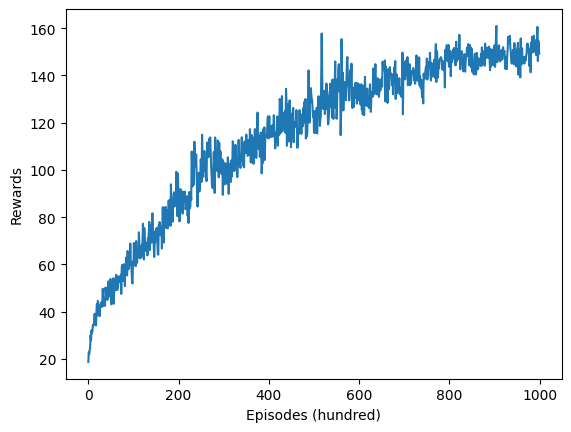

In [11]:
qlearning_agent = QLearningAgent(world,to_load_pickle=False,to_save_pickle=False,
                                 epsilon_decay=MULTIPLICATIVE_DECAY, learing_rate_min=0.01)
reward_list = qlearning_agent.run_training(100000)
fig, ax = plt.subplots()  
plt.plot(reward_list)
ax.set_ylabel('Rewards')
ax.set_xlabel('Episodes (hundred)')
plt.show()

We hold all other factors constant and test if increasing the minimum learning rate would give better performance of the Q learning agent.



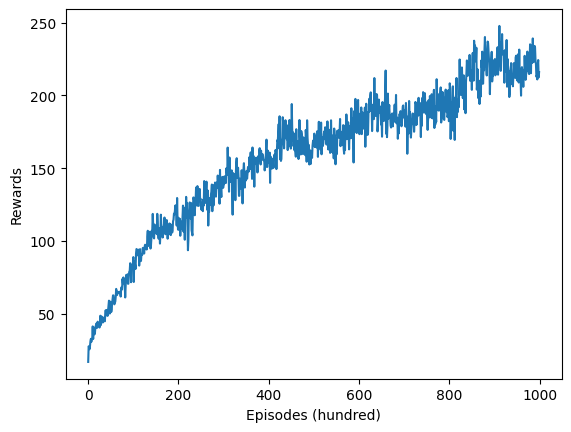

Epsilon: 0.331090, Max epoch: 100000, Current epoch: 100000, Learning rate: 0.049999


In [13]:
qlearning_agent = QLearningAgent(world,to_load_pickle=False,to_save_pickle=False,
                                 epsilon_decay=MULTIPLICATIVE_DECAY, learing_rate_min=0.05)
reward_list = qlearning_agent.run_training(100000)
fig, ax = plt.subplots() 
plt.plot(reward_list)
ax.set_ylabel('Rewards')
ax.set_xlabel('Episodes (hundred)')
plt.show()

KeyboardInterrupt: 

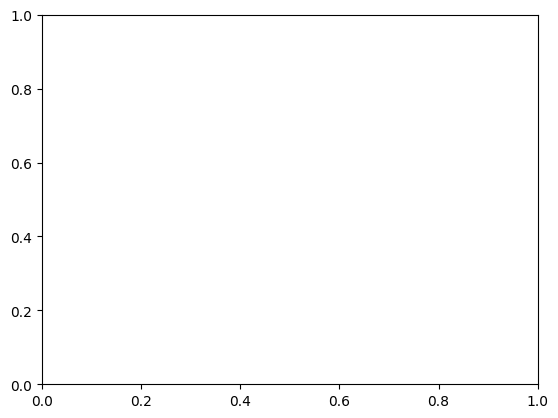

In [12]:
qlearning_agent = QLearningAgent(world,to_load_pickle=False,to_save_pickle=False,
                                 epsilon_decay=MULTIPLICATIVE_DECAY, learing_rate_min=0.1)
fig, ax = plt.subplots()  
reward_list = qlearning_agent.run_training(100000)

plt.plot(reward_list)
ax.set_ylabel('Rewards')
ax.set_xlabel('Episodes (hundred)')
plt.show()

qlearning_agent.print_parameters()

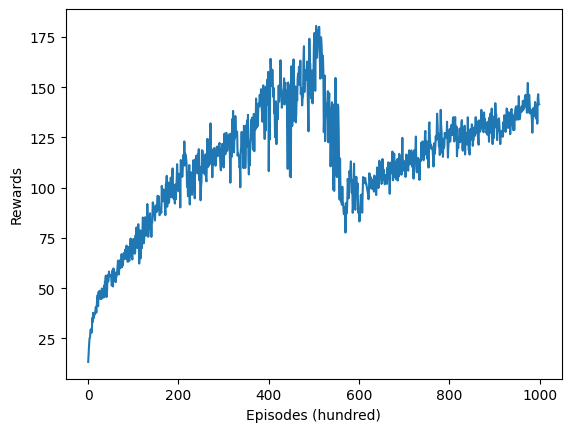

Epsilon: 0.331090, Max epoch: 100000, Current epoch: 100000, Learning rate: 0.199994


In [ ]:
qlearning_agent = QLearningAgent(world,to_load_pickle=False,to_save_pickle=False,
                                 epsilon_decay=MULTIPLICATIVE_DECAY, learing_rate_min=0.2)
fig, ax = plt.subplots()  
reward_list = qlearning_agent.run_training(100000)

plt.plot(reward_list)
ax.set_ylabel('Rewards')
ax.set_xlabel('Episodes (hundred)')
plt.show()

qlearning_agent.print_parameters()

#### Learning rate fixed, Epsilon vary

We hold all other factors constant and test if decreasing the epsilon would improve the rewards.

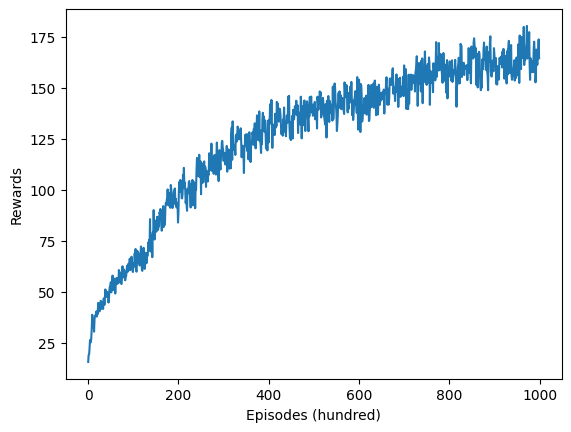

Epsilon: 0.220727, Max epoch: 100000, Current epoch: 100000, Learning rate: 0.049999


In [ ]:
# test epsilon=0.6,epsilon_decay=MULTIPLICATIVE_DECAY, learing_rate_min=0.05
qlearning_agent = QLearningAgent(world,to_load_pickle=False,to_save_pickle=False, epsilon=0.6,
                                 epsilon_decay=MULTIPLICATIVE_DECAY, learing_rate_min=0.05)
fig, ax = plt.subplots()  
reward_list = qlearning_agent.run_training(100000)

plt.plot(reward_list)
ax.set_ylabel('Rewards')
ax.set_xlabel('Episodes (hundred)')
plt.show()

qlearning_agent.print_parameters()

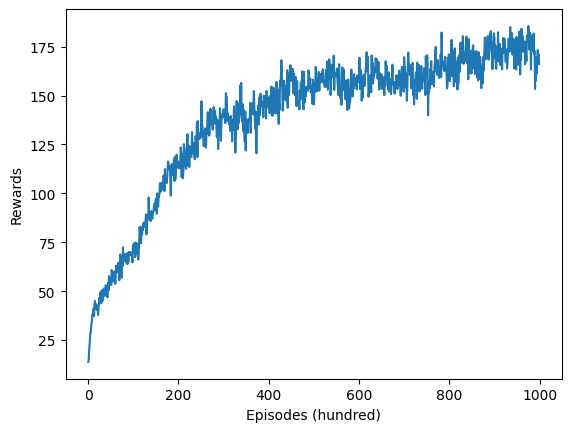

Epsilon: 0.147151, Max epoch: 100000, Current epoch: 100000, Learning rate: 0.049999


In [ ]:
# test epsilon=0.4,epsilon_decay=MULTIPLICATIVE_DECAY, learing_rate_min=0.05
qlearning_agent = QLearningAgent(world,to_load_pickle=False,to_save_pickle=False, epsilon=0.4,
                                 epsilon_decay=MULTIPLICATIVE_DECAY, learing_rate_min=0.05)
fig, ax = plt.subplots()  
reward_list = qlearning_agent.run_training(100000)

plt.plot(reward_list)
ax.set_ylabel('Rewards')
ax.set_xlabel('Episodes (hundred)')
plt.show()

qlearning_agent.print_parameters()

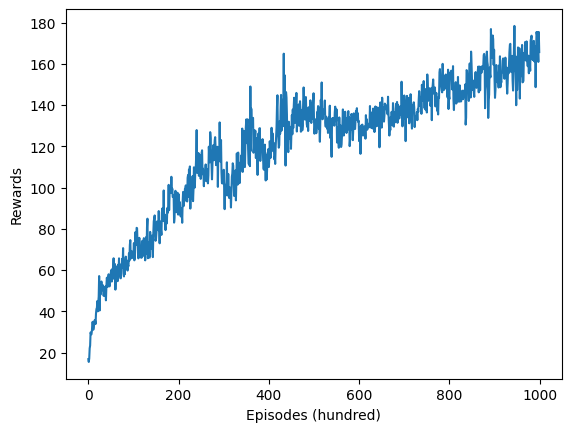

Epsilon: 0.404665, Max epoch: 100000, Current epoch: 100000, Learning rate: 0.049999


In [ ]:
# test epsilon=1.1,epsilon_decay=MULTIPLICATIVE_DECAY, learing_rate_min=0.05
qlearning_agent = QLearningAgent(world,to_load_pickle=False,to_save_pickle=False, epsilon=1.1,
                                 epsilon_decay=MULTIPLICATIVE_DECAY, learing_rate_min=0.05)
fig, ax = plt.subplots()  
reward_list = [qlearning_agent.run_training_for_plot(100) for _ in range(1000)]

plt.plot(reward_list)
ax.set_ylabel('Rewards')
ax.set_xlabel('Episodes (hundred)')
plt.show()

qlearning_agent.print_parameters()

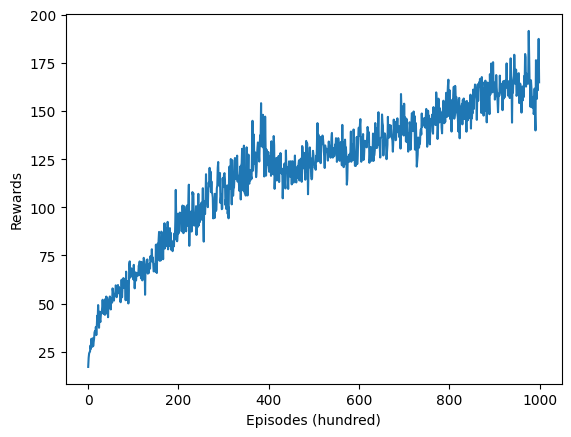

Epsilon: 0.551816, Max epoch: 100000, Current epoch: 100000, Learning rate: 0.049999


In [ ]:
# test epsilon=1.5,epsilon_decay=MULTIPLICATIVE_DECAY, learing_rate_min=0.05
qlearning_agent = QLearningAgent(world,to_load_pickle=False,to_save_pickle=False, epsilon=1.5,
                                 epsilon_decay=MULTIPLICATIVE_DECAY, learing_rate_min=0.05)
fig, ax = plt.subplots()  
reward_list = [qlearning_agent.run_training_for_plot(100) for _ in range(1000)]

plt.plot(reward_list)
ax.set_ylabel('Rewards')
ax.set_xlabel('Episodes (hundred)')
plt.show()

qlearning_agent.print_parameters()

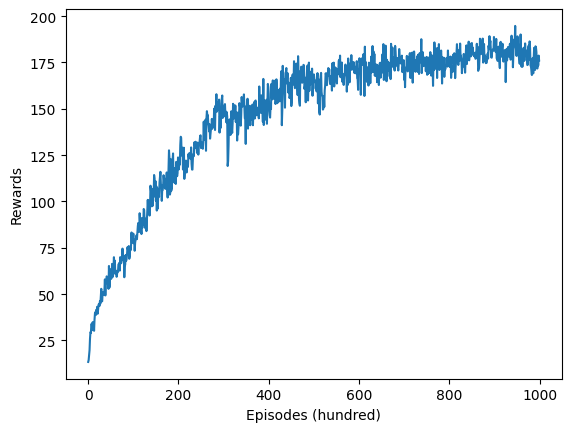

Epsilon: 0.110363, Max epoch: 100000, Current epoch: 100000, Learning rate: 0.010000


In [ ]:
# test epsilon=0.3,epsilon_decay=MULTIPLICATIVE_DECAY, learing_rate_min=0.01
qlearning_agent = QLearningAgent(world,to_load_pickle=False,to_save_pickle=False, epsilon=0.3,
                                 epsilon_decay=MULTIPLICATIVE_DECAY, learing_rate_min=0.01)
fig, ax = plt.subplots()  
reward_list = [qlearning_agent.run_training_for_plot(100) for _ in range(1000)]

plt.plot(reward_list)
ax.set_ylabel('Rewards')
ax.set_xlabel('Episodes (hundred)')
plt.show()

qlearning_agent.print_parameters()

#### Exponential decay on varying learning rate


We also want to check what is the growth of the agent is like for exponential decay.

we can see a sharp decline in the learning before recovering again for both curves, signalling that the S shaped exponential decay might be a bad choice for this environment.

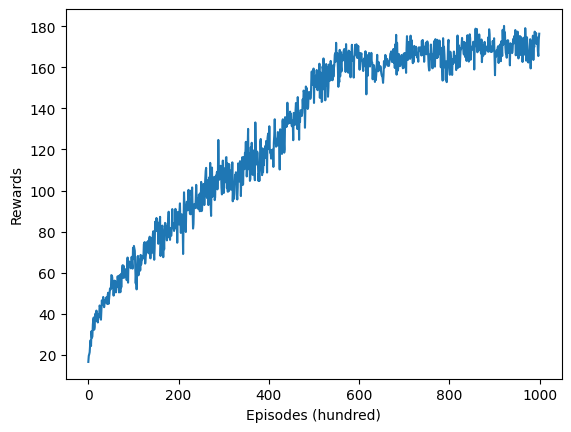

Epsilon: 0.009999, Max epoch: 100000, Current epoch: 90163, Learning rate: 0.010000


In [ ]:
qlearning_agent = QLearningAgent(world,to_load_pickle=False,to_save_pickle=False,
                                 epsilon_decay=EXPONENTIAL_DECAY, learing_rate_min=0.01)
fig, ax = plt.subplots()  
reward_list = [qlearning_agent.run_training_for_plot(100) for _ in range(1000)]

plt.plot(reward_list)
ax.set_ylabel('Rewards')
ax.set_xlabel('Episodes (hundred)')
plt.show()

qlearning_agent.print_parameters()

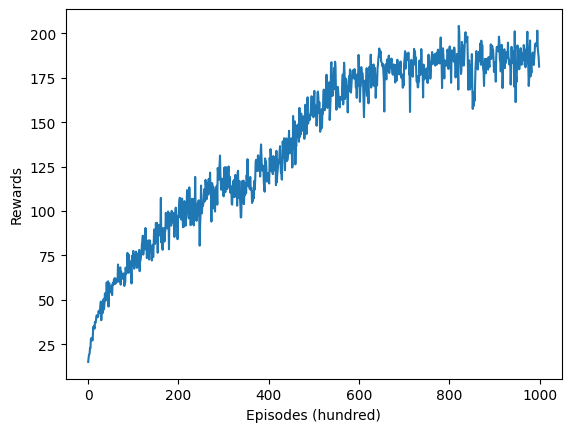

Epsilon: 0.009999, Max epoch: 100000, Current epoch: 90163, Learning rate: 0.049999


In [ ]:
qlearning_agent = QLearningAgent(world,to_load_pickle=False,to_save_pickle=False,
                                 epsilon_decay=EXPONENTIAL_DECAY, learing_rate_min=0.05)
fig, ax = plt.subplots()  
reward_list = [qlearning_agent.run_training_for_plot(100) for _ in range(1000)]

plt.plot(reward_list)
ax.set_ylabel('Rewards')
ax.set_xlabel('Episodes (hundred)')
plt.show()

qlearning_agent.print_parameters()

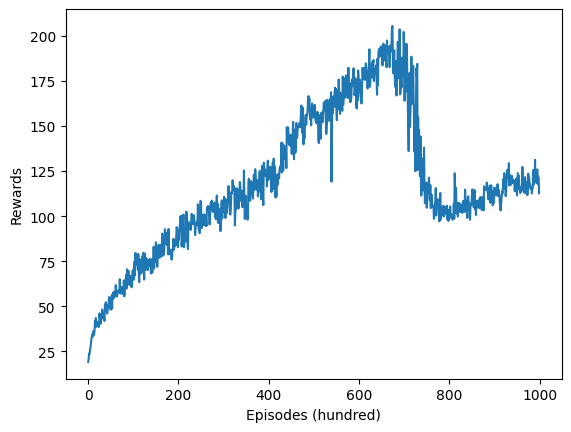

Epsilon: 0.009999, Max epoch: 100000, Current epoch: 90163, Learning rate: 0.100000


In [ ]:
qlearning_agent = QLearningAgent(world,to_load_pickle=False,to_save_pickle=False,
                                 epsilon_decay=EXPONENTIAL_DECAY, learing_rate_min=0.1)
fig, ax = plt.subplots()  
reward_list = [qlearning_agent.run_training_for_plot(100) for _ in range(1000)]

plt.plot(reward_list)
ax.set_ylabel('Rewards')
ax.set_xlabel('Episodes (hundred)')
plt.show()

qlearning_agent.print_parameters()

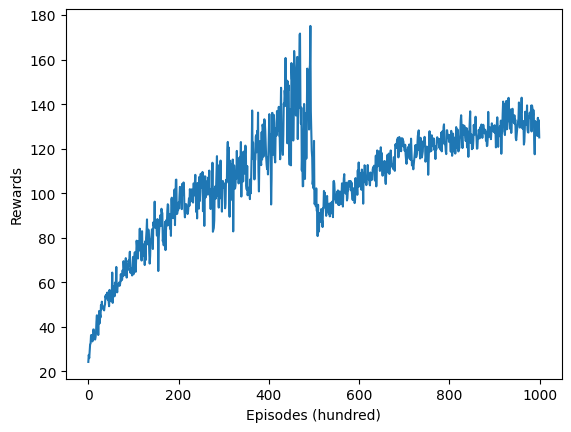

Epsilon: 0.009999, Max epoch: 100000, Current epoch: 90163, Learning rate: 0.199994


In [ ]:
qlearning_agent = QLearningAgent(world,to_load_pickle=False,to_save_pickle=False,
                                 epsilon_decay=EXPONENTIAL_DECAY, learing_rate_min=0.2)
fig, ax = plt.subplots()  
reward_list = [qlearning_agent.run_training_for_plot(100) for _ in range(1000)]

plt.plot(reward_list)
ax.set_ylabel('Rewards')
ax.set_xlabel('Episodes (hundred)')
plt.show()

qlearning_agent.print_parameters()

#### Choosing the best hyper parameters

Having tested different parameters, we have identified the 2 best graph which gets the agent to about 400rewards with the shortest training time.

In [ ]:
qlearning_agent = QLearningAgent(world,to_load_pickle=False,to_save_pickle=False,
                                 epsilon_decay=EXPONENTIAL_DECAY, learing_rate_min=0.1)
reward_list = qlearning_agent.train_till_complete(400,100)
fig, ax = plt.subplots()  
plt.plot(reward_list)
ax.set_ylabel('Rewards')
ax.set_xlabel('Episodes (hundred)')
plt.show()

### Correctness of implementation

In [ ]:
observation = world.resetWorld()
action = qlearning_agent.get_optimal_action(observation)
print(f"{observation}")
print(f"Chosen Action: {action}")

# Task 2:

Demonstrate the effectiveness of the RL agent. Run for 100 episodes (reset the environment at the beginning of each episode) and plot the cumulative reward against all episodes in Jupyter. Print the average reward over the 100 episodes. The average reward should be larger than 195.

### 2a) Effectiveness of MC Agent

The code below loads the pickle file containing the pickle file for the agent to load from.

In [ ]:
mc_agent = MCAgent(world,load_pickle=True)
episode_results = np.asarray([mc_agent.run_single_episode() for _ in range(100)])

plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Print the average reward over the 100 episodes.

In [ ]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

### 2b) Effectiveness of Q-Learning Agent

The code below loads the pickle file containing the pickle file for the agent to load from.

In [ ]:
qlearning_agent = QLearningAgent(world,to_load_pickle=True)
episode_results = np.asarray([qlearning_agent.run_single_episode_production() for _ in range(100)])

plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

In [ ]:
print("Average cumulative reward:", episode_results.mean())
print("Is my agent good enough?", episode_results.mean() > 195)

# Task 3:
Render one episode played by the developed RL agent on Jupyter. Please refer to the sample code link for rendering code

In [ ]:
'''
Run one episode of the q-learning agent here, with render = True
'''

## Observations

1. The initial average reward (100 runs) for Q-learning starts of very low at around 10 due to the initial random policy, however MC control leverages on domain knowledge (physics rules) from which causes the starting average reward to be higher at around 40.
2. Initial growth rate of both agents are similar. Both displayed similar curvature, but on average Q-learning performed better slightly with a higher reward score at the end of 10,000 iterations. We also note that the MC control agent is not selecting actions by random, but is using domain knowledge information to select the best action when a new state is encountered which could skew the results.
3. Overall long term growth rate of Q-learning is still faster than MC control as it utilises each state to make the optimal action, and thus requiring less episodes to converge to the optimal.
4. The use of decaying epsilon and learning rate supported both agents to reach local minima in a shorter time. Bigger steps are taken during the initial stages and as the agent approaches the minima, smaller steps are taken to ensure that the agents do not miss the minima



# Task 4:

Format the Jupyter notebook by including step-by-step instruction and explanation, such that the notebook is easy to follow and run (refer to the tutorial section in the sample notebook). Include text explanation to demonstrate the originality of your implementation and your understanding of the code. For example, for each task, explain your approach and analyze the output; if you improve an existing approach, explain your improvements.

# Appendix A: Optimal Solution using Physics

[Tang, Eric. "How to Beat the Cartpole Game in 5 Lines." Towards Data Science, 23 Apr. 2018](https://towardsdatascience.com/how-to-beat-the-cartpole-game-in-5-lines-5ab4e738c93f)

In our research, we came across this article which analyzes the cartpole problem. By identifying the physics behind the problem, they were able to derive the optimal policy as follows:

- When the angle θ is “small”, we want to stabilize θ. This is the same as the Omega Policy.
- When the angle θ is “large”, we want to correct θ, i.e., give an angular acceleration towards the center.

We implement a physics agent using the optimal policy as follows:

In [ ]:
class PhysicsAgent(RLAgent):
    
    def __init__(self, env:CartpoleWorld) -> None:
        super().__init__(env)

    def run_production(self, num_of_episode: int) -> None:
        cumulated_reward = 0
        for _ in range(num_of_episode):
            current_reward = self.run_single_episode_production()
            cumulated_reward += current_reward
        print(f"Mean reward is: {cumulated_reward/num_of_episode}")

    def run_single_episode_production(self) -> int:
        # clear history
        self._env.resetWorld()
        self._total_reward = 0
        while (not self._env.isEnd()):
            ndarry: Observation = self._env.get_observation()
            s = self.wrap_observation(ndarry)
            self.move(s)
        return self._total_reward
    
    
    def get_optimal_action(self, s: Observation) -> int:
        """Reference: https://towardsdatascience.com/how-to-beat-the-cartpole-game-in-5-lines-5ab4e738c93f
            Overrides abstract base class
        """
        theta, w = s[2:4]
        if abs(theta) < 0.03:
            return 0 if w < 0 else 1
        else:
            return 0 if theta < 0 else 1
        
physics_agent = PhysicsAgent(world)

Effectiveness of optimal Physics Agent

In [ ]:
episode_results = np.asarray([physics_agent.run_single_episode_production() for _ in range(100)])

plt.plot(episode_results)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('episode')
plt.show()

Render one episode played by the optimal physics agent on Jupyter

In [ ]:
'''
Run one episode of the physics agent here, with render = True
'''